In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Colab Notebooks/explore/ai/14_16_cnn")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 使用TF构建卷积神经网络
在这篇notebook文档中，我们将:

- 实现一些工具函数
- 利用这些函数构建一个功能完整的CNN

通过本文档，你将学会使用TensorFlow创建并训练CNN来进行图像分类。

**本篇文档需要的tensorflow是1.2.1。所以我们首先要调整电脑上的tensorflow版本。**

方法如下

- 关闭所有浏览器和jupyter notebook。当然也包括关闭本文档了。
- 从window菜单里打开Anaconda Prompt
- 在里面执行activate tensorflow命令
- 然后在里面执行pip install tensorflow==1.2.1 --upgrade
- 成功后再打开本文档

开发环境的不同，有时候可能会导致很莫名其妙的问题，所以大家一定要保持与我的开发环境一致。

## 1.0 - 准备数据集

首先，还是要加载一些工具库

In [ ]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *

%matplotlib inline
np.random.seed(1)

运行下面的单元来加载数据集,它里面包含的是0到5的手势。

In [ ]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

<img width=800 src="https://z3.ax1x.com/2021/09/12/49luQI.png">

下面的单元会将数据集里面的某个样本的图片已经它对应的数字打印出来。你可以更改一下index的值，让它打印出不同的样本。

y = 2


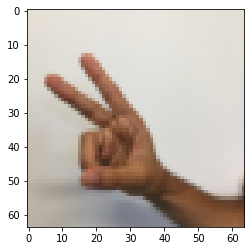

In [ ]:
index = 6
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

其实在第二章的时候，我们就已经接触了这个数据集。当时我们是在它上面构建了一个全链接神经网络。其实我们应该使用CNN，因为这些数据是图片。就如我们教程中所说的，只要提到智能视觉，那么就应该想到CNN。

下面我们先把这些数据的维度打印出来。因为编程中常常会出现因为维度错乱而导致bug出现。而且一旦出现了还很不好查，所以我们会在很多地方把维度信息打印出来。即可以防止出现维度错乱，又可以在出现bug后帮助定位问题。

In [ ]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("训练样本数 = " + str(X_train.shape[0]))
print ("测试样本数 = " + str(X_test.shape[0]))
print ("X_train的维度: " + str(X_train.shape))
print ("Y_train的维度: " + str(Y_train.shape))
print ("X_test的维度: " + str(X_test.shape))
print ("Y_test的维度: " + str(Y_test.shape))
conv_layers = {}

训练样本数 = 1080
测试样本数 = 120
X_train的维度: (1080, 64, 64, 3)
Y_train的维度: (1080, 6)
X_test的维度: (120, 64, 64, 3)
Y_test的维度: (120, 6)


### 1.1 - 创建占位符（placeholders）

要使用TensorFlow，首先我们需要为训练数据准备好占位符，这样一来，在运行tensorflow session时我们就可以把数据填充到占位符中供TensorFlow使用。

下面的函数会为样本X和标签Y分别创建占位符。在代码中我们没有指定样本的数量，因为这样会使代码更加灵活，可以让我们在后面才决定样本数量。

In [ ]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """    
    参数:
    n_H0 -- 图像矩阵的高
    n_W0 -- 图像矩阵的宽
    n_C0 -- 图像矩阵的深度
    n_y -- 标签类别数量，我们的数据集是0到5的手势，所以有6个类别
        
    返回值:
    X -- 样本数据的占位符
    Y -- 标签的占位符
    """ 
    # 下面使用None来表示样本数量，表示当前还不确定样本数量
    X = tf.compat.v1.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    Y = tf.compat.v1.placeholder(tf.float32, [None, n_y])
    
    return X, Y

In [ ]:
X, Y = create_placeholders(64, 64, 3, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder_2:0", shape=(None, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_3:0", shape=(None, 6), dtype=float32)


### 1.2 - 初始化参数


In [ ]:
def initialize_parameters():
    
    tf.compat.v1.set_random_seed(1)                            
        
    #使用`tf.contrib.layers.xavier_initializer(seed = 0)`来初始化W1。
    # W1的维度是[4, 4, 3, 8],表示第一个卷积层过滤器矩阵的[高，宽，深度，个数]
    W1 = tf.compat.v1.get_variable("W1", [4, 4, 3, 8], initializer=tf.keras.initializers.glorot_normal(seed=0))
    #初始化W2
    W2 = tf.compat.v1.get_variable("W2", [2, 2, 8, 16], initializer=tf.keras.initializers.glorot_normal(seed=0))
    
    #有同学会问，为什么不初始化阈值和全连接层的相关参数呢？
    #因为TensorFlow会自动初始化它们，不需要我们操心

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [ ]:
tf.compat.v1.reset_default_graph()
with tf.compat.v1.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.compat.v1.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"].eval()[1,1,1]))
    print("W2 = " + str(parameters["W2"].eval()[1,1,1]))

W1 = [-0.0823642  -0.06239164  0.0692583  -0.08870617  0.0596662  -0.00965765
  0.09378073  0.0338135 ]
W2 = [ 0.0385498  -0.102188   -0.13154894  0.00638634  0.15021302 -0.15281421
  0.09389147 -0.14791884 -0.32294592 -0.12174041  0.00075864 -0.07553802
 -0.13327168 -0.10095861  0.2578219  -0.08296331]


### 1.2 - 前向传播

TensorFlow提供了一些CNN相关的工具函数。

- **tf.nn.conv2d(X,W1, strides = [1,s,s,1], padding = 'SAME'):** X是指输入矩阵，W1是指过滤器。这个函数会将X和W1进行卷积。strides是指各个维度的卷积步长，[1,s,s,1]的含义分别是[样本数，输入矩阵的高，输入矩阵的宽，输入矩阵的深度]。padding是指填补数量，默认使用SAME填补，也就是自动填补一定数量元素而保证输入矩阵与输出矩阵的尺寸一样。


- **tf.nn.max_pool(A, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME'):** 这个函数会对输入矩阵A进行最大池化。ksize中的f表示池化窗口的大小。strides中的s表示步长。


- **tf.nn.relu(Z1):** 对Z1中的每一个元素进行relu激活


- **tf.contrib.layers.flatten(P)**: 它会将P中样本的矩阵扁平化成向量。


- **tf.contrib.layers.fully_connected(F, num_outputs):** 构建一个全连接层，F是该层的输入，num_outputs表示该层中神经元的个数。这个函数会自动初始化该层的权重w。我们在前面只初始化了卷积层相关的参数,因为TensorFlow会自动帮我们初始化全链接层的参数。

In [ ]:
def forward_propagation(X, parameters):
    """
    这个函数会实现如下的前向传播流程:
    CONV2D卷积 -> RELU激活 -> MAXPOOL池化 -> CONV2D卷积 -> RELU激活 -> MAXPOOL池化 -> FLATTEN扁平化 -> 全连接层
    
    参数:
    X -- 输入特征的占位符
    parameters -- 之前我们初始化好的"W1", "W2"参数

    Returns:
    Z3 -- 最后一个全连接层的输出
    """
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    Z1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME')

    A1 = tf.nn.relu(Z1)
    
    P1 = tf.nn.max_pool(A1, ksize = [1, 8, 8, 1], strides = [1, 8, 8, 1], padding='SAME')

    Z2 = tf.nn.conv2d(P1, W2, strides=[1, 1, 1, 1], padding='SAME')

    A2 = tf.nn.relu(Z2)
    
    P2 = tf.nn.max_pool(A2, ksize = [1, 4, 4, 1], strides = [1, 4, 4, 1], padding='SAME')

    P = tf.compat.v1.layers.flatten(P2)
    # 指定该全连接层有6个神经元。
    # activation_fn=None表示该层没有激活函数，因为后面我们会再接一个softmax层
    Z3 = tf.compat.v1.layers.dense(P, 6, activation=None)

    return Z3

In [ ]:
tf.compat.v1.reset_default_graph()
with tf.compat.v1.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    init = tf.compat.v1.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,64,64,3), Y: np.random.randn(2,6)})
    print("Z3 = " + str(a))

Z3 = [[ 0.4586781  -0.00787592 -0.80852795 -0.2417118  -0.01923245 -2.0902004 ]
 [ 0.6130029   0.2485256  -0.6504681  -0.35885742 -0.07680291 -2.0282626 ]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:541: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


### 1.3 - 计算损失

In [ ]:
def compute_cost(Z3, Y):
    """
    参数:
    Z3 -- 前面forward_propagation的输出结果，维度是(6, 样本数)
    Y -- 真实标签的占位符，维度当然也是(6, 样本数)
    
    返回值:
    cost - 返回一个tensorflow张量，它代表了softmax激活以及成本计算操作。
    """
    
    # tf.nn.softmax_cross_entropy_with_logits函数不仅仅执行了softmax激活，还将成本也给计算了。
    # tf.reduce_mean本用来获取平均值。在这里被用于获取多个样本的平均损失，即获取成本。
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y))
    
    return cost

In [ ]:
tf.compat.v1.reset_default_graph()

with tf.compat.v1.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    init = tf.compat.v1.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,64,64,3), Y: np.random.randn(4,6)})
    print("cost = " + str(a))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:541: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


cost = 0.11395657


## 1.4 构建模型

最终，我们将上面那些工具函数组合起来，构建一个CNN网络模型。并且用手势数据集来训练它。

In [ ]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.009,
          num_epochs=100, minibatch_size=64, print_cost=True):
    """
    参数:
    X_train -- 训练集数据，维度是(1080, 64, 64, 3)
    Y_train -- 训练集标签, 维度是(1080, 6)
    X_test -- 测试集数据, 维度是(120, 64, 64, 3)
    Y_test -- 测试集标签, 维度是(120, 6)
    
    返回值:
    train_accuracy -- 训练集上的预测精准度
    test_accuracy -- 测试集上的预测精准度
    parameters -- 训练好的参数
    """
    
    ops.reset_default_graph()                         # 重置一下tf框架
    tf.compat.v1.set_random_seed(1)                       
    seed = 3                                       
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]   # n_y是标签的类别数量，这里是6
    costs = []                                     
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    parameters = initialize_parameters()

    Z3 = forward_propagation(X, parameters)

    cost = compute_cost(Z3, Y)

    
    # 我们使用adam来作为优化算法
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.compat.v1.global_variables_initializer()
     
    with tf.compat.v1.Session() as sess:
        
        sess.run(init)
        
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) 
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch
                # 执行session。训练正式开始。每一次训练一个子训练集minibatch
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
                

            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # 计算预测精准度
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("训练集预测精准度:", train_accuracy)
        print("测试集预测精准度:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:541: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Cost after epoch 0: 1.914275
Cost after epoch 5: 1.506452
Cost after epoch 10: 1.143499
Cost after epoch 15: 1.072914
Cost after epoch 20: 0.953063
Cost after epoch 25: 0.923133
Cost after epoch 30: 0.866106
Cost after epoch 35: 0.850391
Cost after epoch 40: 0.805269
Cost after epoch 45: 0.824156
Cost after epoch 50: 0.762256
Cost after epoch 55: 0.730087
Cost after epoch 60: 0.717798
Cost after epoch 65: 0.739458
Cost after epoch 70: 0.715713
Cost after epoch 75: 0.739861
Cost after epoch 80: 0.717883
Cost after epoch 85: 0.653904
Cost after epoch 90: 0.663193
Cost after epoch 95: 0.665270


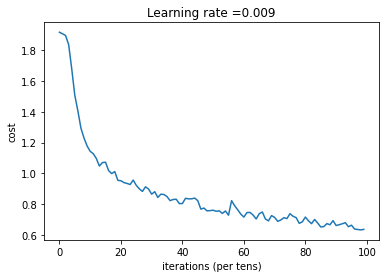

Tensor("Mean_1:0", shape=(), dtype=float32)
训练集预测精准度: 0.78425926
测试集预测精准度: 0.65833336


In [ ]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

预测精准度有可能会上下浮动一点点。

训练集预测精准度: 0.86851853
测试集预测精准度: 0.73333335
恭喜！我们一起构建了一个可以识别手语CNN程序，识别率达到了75%左右。当然，你还可以继续提升它，通过微调超参数，以及使用我们在第3章中学到的知识来分析优化它。

坚持跟我学到了现在，值得表扬，给你个大拇指！去逛逛放松放松吧！

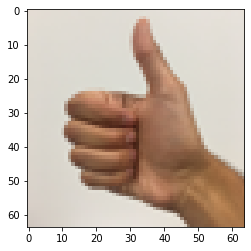

In [ ]:
fname = "images/thumbs_up.jpg"
image = np.array(plt.imread(fname))
my_image = np.array(Image.fromarray(image).resize((64,64)));
plt.imshow(my_image)